In [2]:
%matplotlib inline
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import numpy as np
figsize(12.5, 4)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import pymc3 as pm
import theano.tensor as T

## Step 1 - Observe the Real Data

* The Data below is the real observations.
* We can see 2 peaks in the data, one with the center around 120 and the other with the center around 200.
* Felt like binominal distribution that an observation falls into either cluster 1 or cluster 2

[115.85679142 152.26153716 178.87449059 162.93500815 107.02820697
 105.19141146 118.38288501 125.3769803  102.88054011 206.71326136] ...


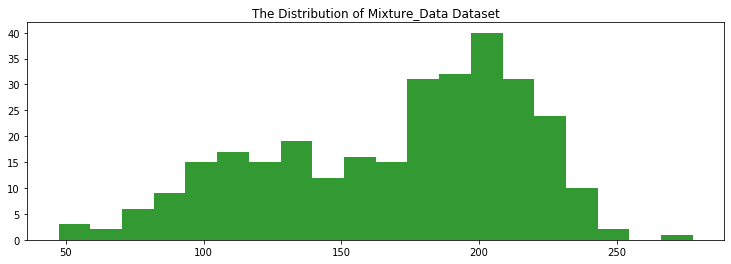

In [4]:
figsize(12.5, 4)
data = np.loadtxt("../data/mixture_data.csv", delimiter=",")

plt.hist(data, bins=20, color="g", histtype="stepfilled", alpha=0.8)
plt.title("The Distribution of Mixture_Data Dataset")
plt.ylim([0, None]);
print(data[:10], "...")

## Step 2 - Generate the Data with Priors

### Assign Clusters
* `pm.Categorical`
  * Its parameter is a k-length array of probabilities that must sum to one 
  * Its value attribute is a integer between 0 and k-1 randomly chosen according to the crafted array of probabilities (In our case k=2)
* Since we don't know the probability to assign to which cluster in prior, so use uniform distribution here

In [83]:
with pm.Model() as model:
    p1 = pm.Uniform('p', 0, 1)
    p2 = 1 - p1
    p = T.stack([p1, p2])
    assignment = pm.Categorical("assignment", p, 
                                shape=data.shape[0],
                                testval=np.random.randint(0, 2, data.shape[0]))
    
print("prior assignment, with p = %.2f:" % p1.tag.test_value)
print(assignment.tag.test_value[:10])

prior assignment, with p = 0.50:
[0 0 0 1 1 1 1 0 0 0]


### Assign `μ`， `σ` of the Cluster to each Observation

In [6]:
with model:
    sds = pm.Uniform("sds", 0, 100, shape=2)
    centers = pm.Normal("centers", 
                        mu=np.array([120, 200]), 
                        sd=np.array([10, 10]), 
                        shape=2)
    
    center_i = pm.Deterministic('center_i', centers[assignment])
    sd_i = pm.Deterministic('sd_i', sds[assignment])
    
    # combine with the real observations:
    observations = pm.Normal("obs", mu=center_i, sd=sd_i, observed=data)
    
print("Random assignments: ", assignment.tag.test_value[:10], "...")
print("Assigned center: ", center_i.tag.test_value[:10], "...")
print("Assigned standard deviation: ", sd_i.tag.test_value[:10], "...")
print("Observations: ", observations.tag.test_value[:10], "...")
print(data[:10], "...")

Random assignments:  [0 0 1 1 0 0 0 1 1 0] ...
Assigned center:  [120. 120. 200. 200. 120. 120. 120. 200. 200. 120.] ...
Assigned standard deviation:  [50. 50. 50. 50. 50. 50. 50. 50. 50. 50.] ...
Observations:  [115.85679142 152.26153716 178.87449059 162.93500815 107.02820697
 105.19141146 118.38288501 125.3769803  102.88054011 206.71326136] ...
[115.85679142 152.26153716 178.87449059 162.93500815 107.02820697
 105.19141146 118.38288501 125.3769803  102.88054011 206.71326136] ...


In [7]:
print(sds.tag.test_value)
print(centers.tag.test_value)

[50. 50.]
[120. 200.]


### Define Sampling Methods to Explore Define Space
* `Metropolis()` for our continuous variables
* `CategoricalGibbsMetropolis()` for categorical variable
* Sample 25000 iterations
  * The results are saved in `trace`, which records the value of specificed `vars` for each observation
    * These `vars` are, `p`, `sds`, `centers` and `assignment`
    
* NOTE:
  * I tried `find_map()` before `sample()`, but it simply doesn't work

In [8]:
with model:
    step1 = pm.Metropolis(vars=[p, sds, centers])
    step2 = pm.CategoricalGibbsMetropolis(vars=[assignment])
    trace = pm.sample(25000, step=[step1, step2])

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [centers]
>>Metropolis: [sds]
>>Metropolis: [p]
>CategoricalGibbsMetropolis: [assignment]
Sampling 4 chains, 0 divergences: 100%|█████████████████████████████████████| 102000/102000 [45:47<00:00, 37.12draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [15]:
print(trace['centers'].shape)
print(trace['p'].shape)
print(trace['sds'].shape)
print(trace['assignment'].shape)

(100000, 2)
(100000,)
(100000, 2)
(100000, 300)


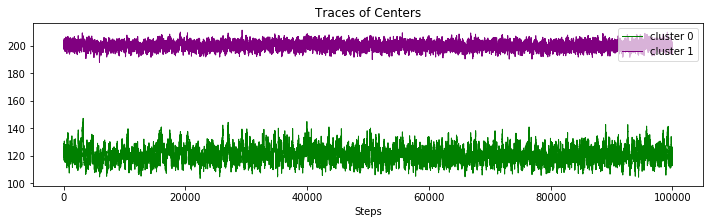

In [37]:
plt.figure(figsize=(12,3))
lw = 1
center_trace = trace["centers"]

plt.plot(center_trace[:, 0], label="cluster 0", c='g', lw=lw)
plt.plot(center_trace[:, 1], label="cluster 1", c='purple', lw=lw)
plt.xlabel('Steps')
plt.title("Traces of Centers")
leg = plt.legend(loc="upper right")
leg.get_frame().set_alpha(0.7)

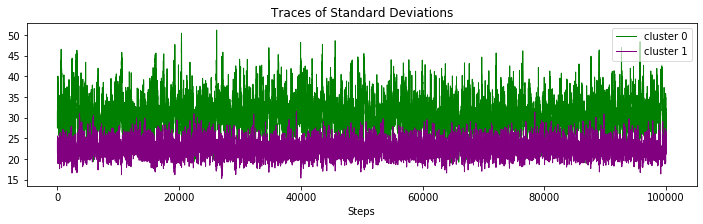

In [38]:
plt.figure(figsize=(12,3))
lw = 1
center_trace = trace["sds"]

plt.plot(std_trace[:, 0], label="cluster 0", c='g', lw=lw)
plt.plot(std_trace[:, 1], label="cluster 1", c='purple', lw=lw)
plt.xlabel('Steps')
plt.title('Traces of Standard Deviations')
leg = plt.legend(loc="upper right")
leg.get_frame().set_alpha(0.7)

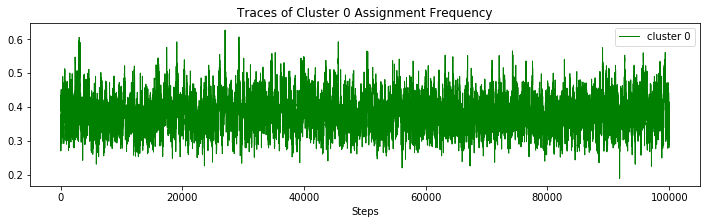

In [40]:
plt.figure(figsize=(12,3))
lw = 1
p_trace = trace["p"]

plt.plot(p_trace, label="cluster 0", c='g', lw=lw)
plt.xlabel('Steps')
plt.title('Traces of Cluster 0 Assignment Frequency')
leg = plt.legend(loc="upper right")
leg.get_frame().set_alpha(0.7)

In [41]:
# Sample 50,000 more to achieve more convergence
with model:
    trace = pm.sample(50000, step=[step1, step2], trace=trace)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [centers]
>>Metropolis: [sds]
>>Metropolis: [p]
>CategoricalGibbsMetropolis: [assignment]
Sampling 4 chains, 0 divergences: 100%|███████████████████████████████████| 202000/202000 [1:29:33<00:00, 37.59draws/s]
The number of effective samples is smaller than 10% for some parameters.


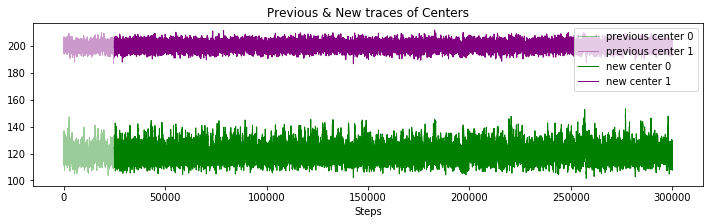

In [51]:
figsize(12, 3)
prev_center_trace = trace["centers"][:25000]
center_trace = trace["centers"][25000:]

x = np.arange(25000)
plt.plot(x, prev_center_trace[:, 0], label="previous center 0",
     lw=lw, alpha=0.4, c='green')
plt.plot(x, prev_center_trace[:, 1], label="previous center 1",
     lw=lw, alpha=0.4, c='purple')

x = np.arange(25000, 300000)
plt.plot(x, center_trace[:, 0], label="new center 0", lw=lw, c="green")
plt.plot(x, center_trace[:, 1], label="new center 1", lw=lw, c="purple")

plt.title("Previous & New traces of Centers")
leg = plt.legend(loc="upper right")
leg.get_frame().set_alpha(0.8)
plt.xlabel("Steps");

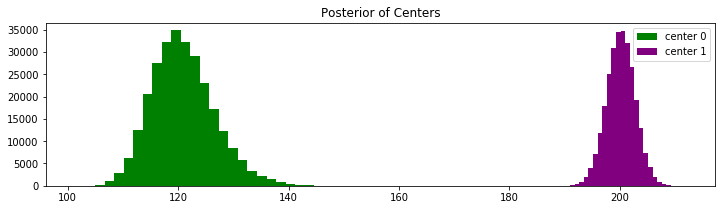

In [54]:
# Plot posterior clusters
figsize(12, 3)
plt.title("Posterior of Centers")
plt.hist(center_trace[:, 0], bins=30, histtype="stepfilled", label='center 0', color='g')
plt.hist(center_trace[:, 1], bins=30, histtype="stepfilled", label='center 1', color='purple')
plt.legend()

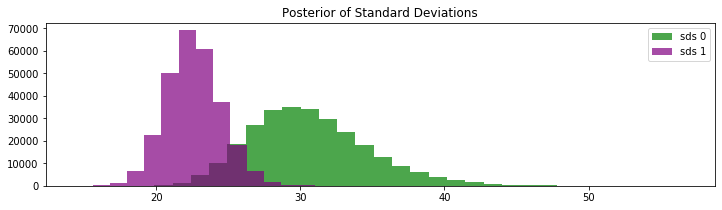

In [57]:
figsize(12, 3)
sds_trace = trace["sds"][25000:]

plt.title("Posterior of Standard Deviations")
plt.hist(sds_trace[:, 0], bins=30, histtype="stepfilled", label='sds 0', color='g', alpha=0.7)
plt.hist(sds_trace[:, 1], bins=30, histtype="stepfilled", label='sds 1', color='purple', alpha=0.7)
plt.legend()

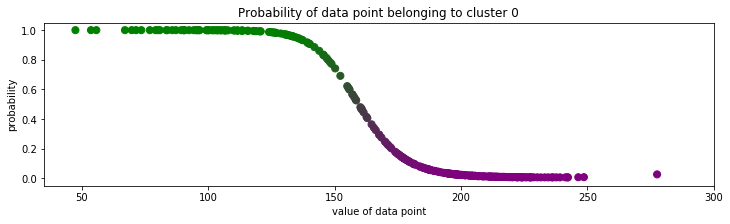

In [68]:
import matplotlib as mpl

cmap = mpl.colors.LinearSegmentedColormap.from_list("BMH", ['green', 'purple'])
assign_trace = trace["assignment"]
plt.scatter(data, 1-assign_trace.mean(axis=0), cmap=cmap,
        c=assign_trace.mean(axis=0), s=50)
plt.ylim(-0.05, 1.05)
plt.xlim(35, 300)
plt.title("Probability of data point belonging to cluster 0")
plt.ylabel("probability")
plt.xlabel("value of data point");

### Check the probability of which cluster a point belongs to

In [76]:
norm_pdf = stats.norm.pdf
p_trace = trace["p"][25000:]

x = 175

v1 = (1-p_trace) * norm_pdf(x, loc=center_trace[:, 1], scale=sds_trace[:, 1]) > \
    p_trace * norm_pdf(x, loc=center_trace[:, 0], scale=sds_trace[:, 0])

v0 = (1-p_trace) * norm_pdf(x, loc=center_trace[:, 1], scale=sds_trace[:, 1]) < \
    p_trace * norm_pdf(x, loc=center_trace[:, 0], scale=sds_trace[:, 0])

print("Probability of belonging to cluster 1:", v1.mean())
print("Probability of belonging to cluster 0:", v0.mean())

Probability of belonging to cluster 1: 0.9883890909090909
Probability of belonging to cluster 0: 0.01161090909090909


### Autocorrelation  & Convergence

* A chain that is not exploring the space well will exhibit very high autocorrelation. Visually, if the trace seems to meander like a river, and not settle down, the chain will have high autocorrelation.
* This does not imply that a converged MCMC has low autocorrelation. Hence low autocorrelation is not necessary for convergence, but it is sufficient. PyMC3 has a built-in autocorrelation plotting function in the plots module.
* Another issue can arise if there is high-autocorrelation between posterior samples. Many post-processing algorithms require samples to be independent of each other. This can be solved, or at least reduced, by only returning to the user every `nth` sample -- <b>Tinning</b>

C:\Users\wuhan\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001736CB9D4C8>,
      dtype=object)

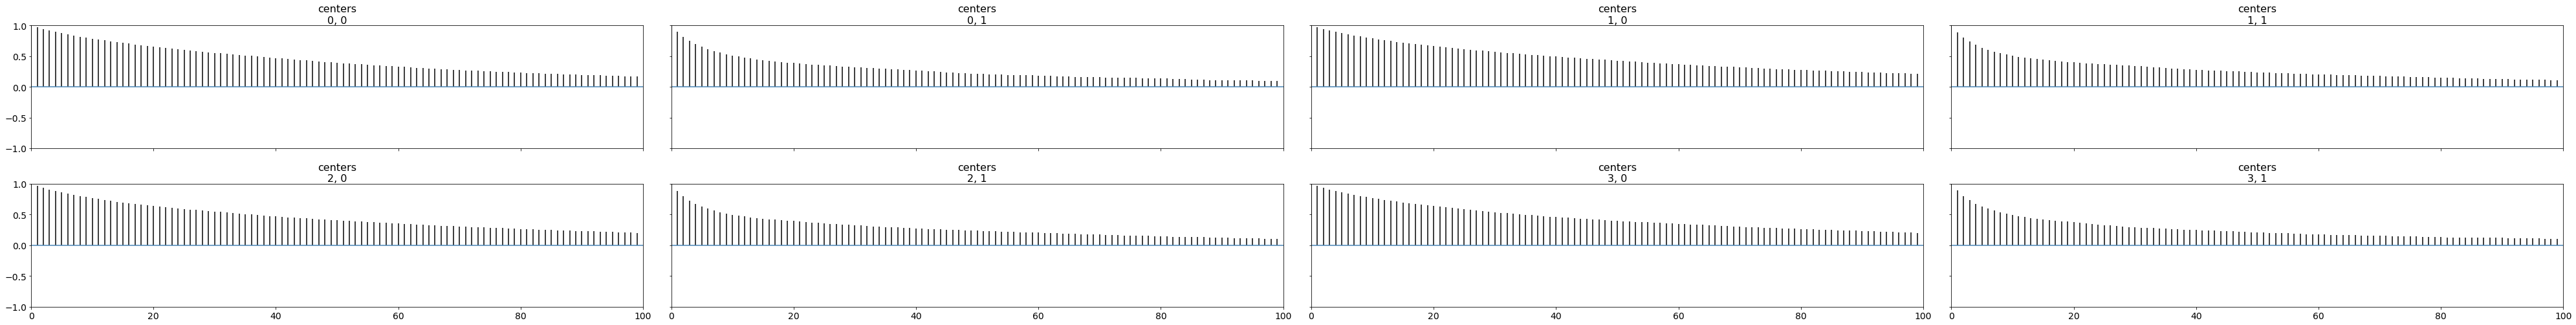

In [99]:
pm.plots.autocorrplot(data=trace, var_names=["centers"])

C:\Users\wuhan\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


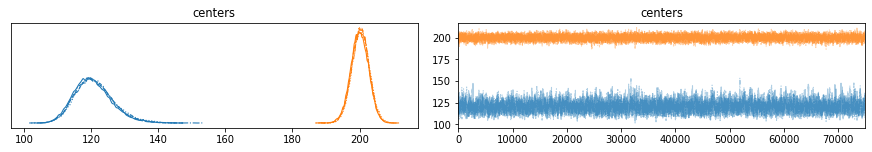

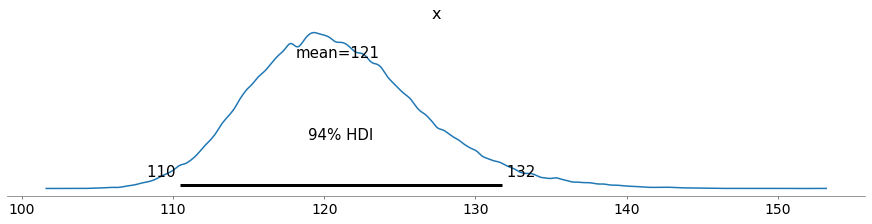

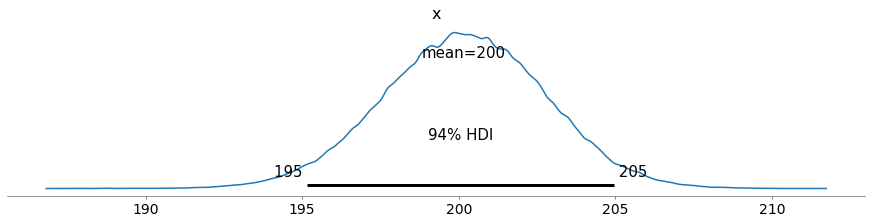

In [100]:
pm.plots.traceplot(data=trace, var_names=["centers"])
pm.plots.plot_posterior(data=trace["centers"][:,0])
pm.plots.plot_posterior(data=trace["centers"][:,1])